# Sampling with PyStan

Ang Zi Qing <br>

27th May 2020<br>
(Edited 30th May 2020)

Sampling is a crucial step to evaluate whether a defined data generating process meets the expectation of a modeler to be a likely model that may describe a set of data and to check how a prior works with a likelihood. This is a record of practicing sampling methods using PyStan by producing samples from the prior predictive distribution, that is, there is no dataset involved for fitting.

## 1. Sample points from an exponential distribution with parameter $\theta$ sampled from a Normal distribution
* Data generating process/Observational Model = Exponential distribution
* Model configuration space = $\theta$

$$X \sim \text{Exponential }(\theta)$$<br>
$$\theta \sim\text{Normal } (0.5,0.05)$$

\begin{align}
X &\sim \text{Exponential }(\theta)\\
\theta &\sim\text{Normal } (0.5,0.05)
\end{align}


Situation: We are going to replicate an experiment where we have a sample of length 100 where each point is assumed to be sampled from a exponential distribution. Experiments are usually done to recover the parameter $\theta$ that was plugged into the observational model that gave us this set of sample. In Bayesian Inference, we are not seeking for a point estimate, but a distribution of possible values for $\theta$ and obtain an average across all possible values. This notebook is not aimed to estimate the parameter $\theta$ but just to practice sampling with PyStan. The first example demonstrates sampling of points, and we will eventually move on to sampling 'functions'. For details of a proper bayesian workflow, see [1].

In [68]:
import pystan as stan
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [246]:
exp_sam =  '''
data {

int N; 

}

parameters {

}

generated quantities {

// Simulate model configuration from prior model
// Since the exponential distribution only takes in positive parameters,
// lower bound of theta is set to zero to ensure positivity.
real<lower=0> theta = normal_rng(0.5,0.05);

// Simulate data from observational model
real y[N];
for (n in 1:N) y[n] = exponential_rng(theta);
}
'''

In [247]:
N = 100
simu_1 = dict(N=N)

In [248]:
sm = stan.StanModel(model_code=exp_sam)
pickle.dump(sm, open('exp_sampling.pkl','wb'))
sm = pickle.load(open('exp_sampling.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f254a58e360025123570cdd5fdff681c NOW.


* 'When "Fixed_param" is used no MCMC sampling is performed (e.g., for simulating within the generated quantities block).'
* 'Fixed_param' is used when no parameters are specified in the `parameters` block.
* 'refresh (integer) can be used to control how often the progress of the sampling is reported'

[Stan Manual](https://mc-stan.org/rstan/reference/stan.html)

In [250]:
fit = sm.sampling(data=simu_1, iter=1000, warmup=0, chains=1, 
                  refresh=1000, seed= 4838282, algorithm='Fixed_param')

In [251]:
simu_lambdas = fit.extract()['theta']
len(simu_lambdas)

1000

What happened was:
1. For each simulation, a $\theta$ is sampled from the Normal distribution.
2. Then using this $\theta$, 100 samples of $y$ are sampled from the exponential distribution.
3. This process is repeated for 1000 times.
4. Now we have a distribution for the 1000 experiments of picking 100 samples from the exponential distribution.
5. Plotting the result of each experiment in histograms, we can observe a distribution of possible outcomes of an experiment.

Value of theta is: 0.4769130437587576.


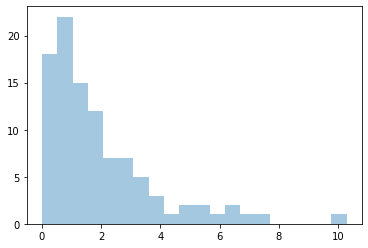

In [252]:
# Example: '1st' experiment/simulation
points_100 = fit.extract()['y'][0]
print(f"Value of theta is: {fit.extract()['theta'][0]}.")
sns.distplot(pd.DataFrame(points_100), bins=20, kde=False)

Value of theta is: 0.5522204100359865.


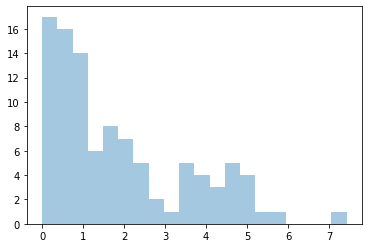

In [253]:
# Example: '100th' experiment/simulation
points_100 = fit.extract()['y'][99]
print(f"Value of theta is: {fit.extract()['theta'][99]}.")
sns.distplot(pd.DataFrame(points_100), bins=20, kde=False)

Value of theta is: 0.5317196782112702.


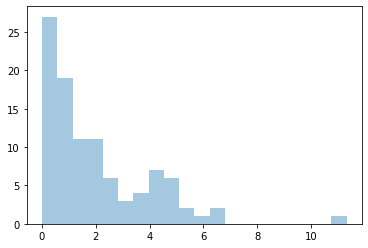

In [254]:
# Example: '1000th' experiment/simulation
points_100 = fit.extract()['y'][-1]
print(f"Value of theta is: {fit.extract()['theta'][-1]}.")
sns.distplot(pd.DataFrame(points_100), bins=20, kde=False)

Overlapping the three histograms together, we can observe that the samples roughly demonstrate the properties of the exponential distribution.

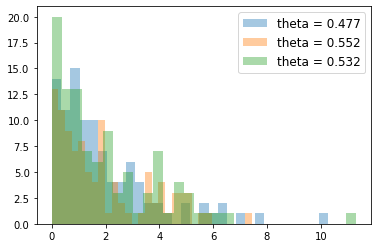

In [255]:
sns.distplot(pd.DataFrame(fit.extract()['y'][0]),  kde=False, label='theta = 0.477', bins=30)
sns.distplot(pd.DataFrame(fit.extract()['y'][99]),  kde=False, label='theta = 0.552', bins=30)
sns.distplot(pd.DataFrame(fit.extract()['y'][-1]),  kde=False, label='theta = 0.532', bins=30)
plt.legend(prop={'size': 12})

Depending on the values of $\theta$ we will have different histograms. The following shows what happens when all histograms of every simulation each depending on varied values of $\theta$ are overlapped. In real life, any given set of data resulting from an experiment is a realization. Suppose that we have the domain knowledge that the data comes from certain distribution, we can narrow down our search to a particular data generating process and focus to estimate the model configuration, that is the parameter of the data generating process that gives us the true data. 

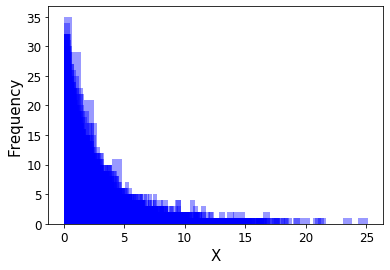

In [186]:
# Plot 100 histograms in one diagram
for i in np.array(range(0,1000)):
    sns.distplot(pd.DataFrame(fit.extract()['y'][i]),  kde=False, color='blue', bins=30)
    
plt.xlabel("X", fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.tick_params(labelsize=12)


Observing the histogram of samples of the model configuration/parameter $\theta$, the samples demonstrates a pattern likely to follow a Normal distribution centered at 0.5.

Text(0, 0.5, 'Frequencies')

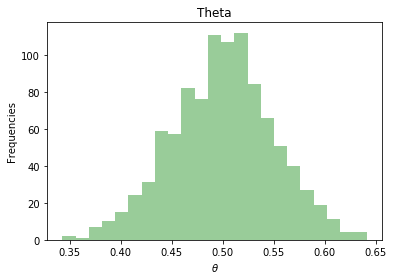

In [187]:
sns.distplot(pd.DataFrame(fit.extract()['theta']), kde=False, color='green')
plt.title('Theta')
plt.xlabel(r'$\theta$')
plt.ylabel('Frequencies')

The summary of the workflow is as follows:
1. Generating prior samples from the prior distribution $p(\theta)$ for 1000 times.
2. For each prior sample, obtain 100 samples from the likelihood function using random number generator.
3. This is equivalent to obtaining samples from the joint distribution, that is the product of the prior distribution and the likelihood. $$p(x,\theta) = p(x\vert \theta)p(\theta)$$
4. Given the samples from the joint distribution, we can then estimate the prior predictive distribution. $$p(x) = \int p(x\vert \theta) p(\theta) d\theta$$

## 2. Sample exponential functions with normal errors.

\begin{align}
g(t) &\sim \text{Normal }\left(f\left(t\vert \theta\right), \sigma\right)\\
f(t\vert \theta) &= 1- e^{-\theta t}\\
\theta &\sim\text{Normal } (1,0.05)\\
\sigma &\sim \text{Normal }(0.2,0.02)
\end{align}

Situation: We are going to replicate an experiment where each experiment results in a time series of 20 time points, which we assume to be somewhat close to the exponential function. So assuming we are going to run 1000 experiments, we should get 1000 time series of 20 time points. The plan is:
1. For each simulation, a $\theta$ and a $\sigma$ will be sampled from each of their prior distributions respectively.
2. Then using this $\theta$, simulate the function at 20 time points using the exponential function.
3. At each time point, add uncertainties by simulating from the Normal distribution with mean being the simulated number from the exponential function and standard deviation given by the sampled $\sigma$.
4. This process is repeated for all 1000 experiments.


In this case, sampling from the joint distribution $$p\left( \;g\left(t\vert \theta\right), \;\theta,\; \sigma\;\right)$$ is equivalent to sampling from $$p\left(\;g\left(t\vert \theta\right)\vert \; \theta, \sigma\;\right)p(\theta)p(\sigma)$$


In [256]:
N = 20
t = np.array(range(1,21))
simu_2 = dict(N=N, t=t)
print(t)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [257]:
exp_func =  '''
data {

int N; 
real<lower=1> t[N];

}

generated quantities {

// Simulate model configuration from prior model
real theta = normal_rng(1,0.05);
real sigma = normal_rng(0.2,0.02); 

// Simulate data from observational model
real g[N];
//real e_func[N];
for (n in 2:N) {
    //e_func[n] = 1 - exp(-(theta * t[n]));
    g[n] = normal_rng((1 - exp(-(theta * t[n]))), sigma);
    }

}

'''

In [258]:
sm = stan.StanModel(model_code=exp_func)
pickle.dump(sm, open('exp_func.pkl','wb'))
sm = pickle.load(open('exp_func.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0fe76511a5a0a6848f7b53f354bb330f NOW.


In [260]:
fit = sm.sampling(data=simu_2, iter=1000, warmup=0, chains=1, 
                  refresh=100, seed= 4838282, algorithm='Fixed_param')

In [261]:
fit

Inference for Stan model: anon_model_0fe76511a5a0a6848f7b53f354bb330f.
1 chains, each with iter=1000; warmup=0; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta    1.0  1.5e-3   0.05    0.9   0.97    1.0   1.03   1.09    995    1.0
sigma    0.2  6.3e-4   0.02   0.16   0.19    0.2   0.21   0.24    984    1.0
g[1]     nan     nan    nan    nan    nan    nan    nan    nan    nan    nan
g[2]    0.85  6.1e-3   0.19   0.47   0.72   0.85   0.98   1.25   1016    1.0
g[3]    0.96  6.4e-3    0.2   0.59   0.83   0.95   1.09   1.37    972    1.0
g[4]    0.99  6.1e-3   0.19    0.6   0.86   0.98   1.12   1.38   1021    1.0
g[5]     1.0  6.4e-3    0.2   0.59   0.87   1.01   1.13   1.36    963    1.0
g[6]    0.99  6.5e-3   0.21   0.55   0.85    1.0   1.13    1.4   1071    1.0
g[7]     1.0  5.9e-3    0.2   0.59   0.86   1.01   1.12   1.37   1120    1.0
g[8]     1.0  6.6e-3   0.21    0.6   0.86   

Text(0, 0.5, 'Frequencies')

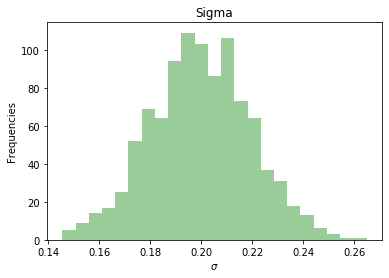

In [262]:
sns.distplot(pd.DataFrame(fit.extract()['sigma']), kde=False, color='green')
plt.title('Sigma')
plt.xlabel(r'$\sigma$')
plt.ylabel('Frequencies')

Text(0, 0.5, 'Frequencies')

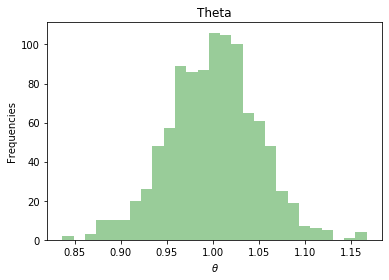

In [263]:
sns.distplot(pd.DataFrame(fit.extract()['theta']), kde=False, color='green')
plt.title('Theta')
plt.xlabel(r'$\theta$')
plt.ylabel('Frequencies')

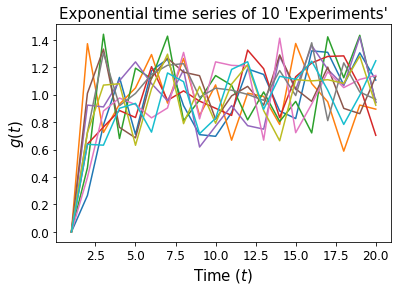

In [264]:
# Plotting the result of the first 10 'experiments'
for i in np.array(range(0,10)):
    A = fit.extract()['g'][i]
    # set value at t=0 to zero
    A[np.isnan(A)] = 0
    plt.plot(t,A)
    
plt.title("Exponential time series of 10 'Experiments'", fontsize=15)
plt.xlabel('Time ($t$)', fontsize=15)
plt.ylabel('$g(t)$', fontsize=15)
plt.tick_params(labelsize=12)

## 3. Sample functions of ODE solutions from a given distribution.
Next, given a set of ODE that describes the dynamics of an epidemic called the SIR model [3], we will try to sample time series of the solutions of the model, namely S(t), I(t), and R(t) given some distribution for each of the parameters. This is just a reproduction of part of the work in [3] using PyStan. I've obtained some help from the Stan community when I was stucked with some flat lines [here](https://discourse.mc-stan.org/t/attempt-to-generate-prior-predictive-samples-from-sir-model/15468).

In [288]:
N = 763
n_days = 31
t = np.array(range(1,n_days+1))
t0 = 0
i0 = 1
r0 = 0
y0 = [N-i0, i0, r0]


simu_3 = dict(n_days = n_days, y0=y0, t0=t0, ts=t, N=N)
print(t)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [267]:
sir_stan = '''
functions {
  real[] sir(real t, real[] y, real[] theta, 
             real[] x_r, int[] x_i) {

      real S = y[1];
      real I = y[2];
      real R = y[3];
      real N = x_i[1];
      
      real beta = theta[1];
      real gamma = theta[2];
      
      real dS_dt = -beta * I * S / N;
      real dR_dt =  gamma * I;
      real dI_dt = -(dS_dt + dR_dt);
      
      return {dS_dt, dI_dt, dR_dt};
  }
}

data {
  int<lower=1> n_days;
  real<lower=0> y0[3];
  real t0;
  real ts[n_days];
  int N;
}

transformed data {
  real x_r[0];
  int x_i[1] = { N };
}

parameters {
  real<lower=0> gamma;
  real<lower=0> beta;
  real<lower=0> phi_inv;
}
transformed parameters{
  real y[n_days, 3];
  real phi = 1. / phi_inv;
  {
    real theta[2];
    theta[1] = beta;
    theta[2] = gamma;

    // Solve ODE at current parameter values
    y = integrate_ode_rk45(sir, y0, t0, ts, theta, x_r, x_i);
  }
  // Adding a small +ve value to ensure strict positivity of y
  for (k in 1:3){
      for (n in 1:n_days){
          y[n,k] = y[n,k] + 0.00001;
          }
    }
}
model {
  //priors
  beta ~ normal(2, 1);
  gamma ~ normal(0.4, 0.5);
  phi_inv ~ exponential(5);
  
}
generated quantities {
  real R0 = beta / gamma;
  real recovery_time = 1 / gamma;
  real pred_cases[n_days];
  pred_cases = neg_binomial_2_rng(col(to_matrix(y), 2), phi);
  // col(to_matrix(y),2) means second column of the matrix y, that is I(t)
}

'''

In [268]:
sm = stan.StanModel(model_code=sir_stan)
pickle.dump(sm, open('sir_stan.pkl','wb'))
sm = pickle.load(open('sir_stan.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdcd212cd20a5595f0575a0eb125fc51 NOW.


In [289]:
fit = sm.sampling(data=simu_3)
y = fit.extract()['y']

(0, 800.9842783464468)

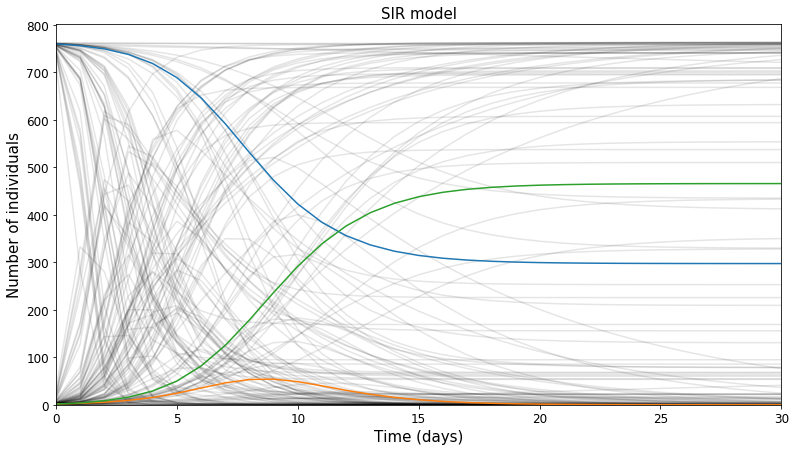

In [291]:
plt.figure(figsize=(13,7))
for i in range(50):
    plt.plot(pd.DataFrame(y[i]),c="k",alpha=0.1)
plt.plot(y[50])
plt.title("SIR model", fontsize=15)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Number of individuals', fontsize=15)
plt.tick_params(labelsize=12)
plt.xlim(0,30) 
plt.ylim(0,) 

It is also possible to just plot samples of the second column of matrix $y$ just like the one in the original paper, which is the 'Infected' compartment.

(0, 801.1499995355287)

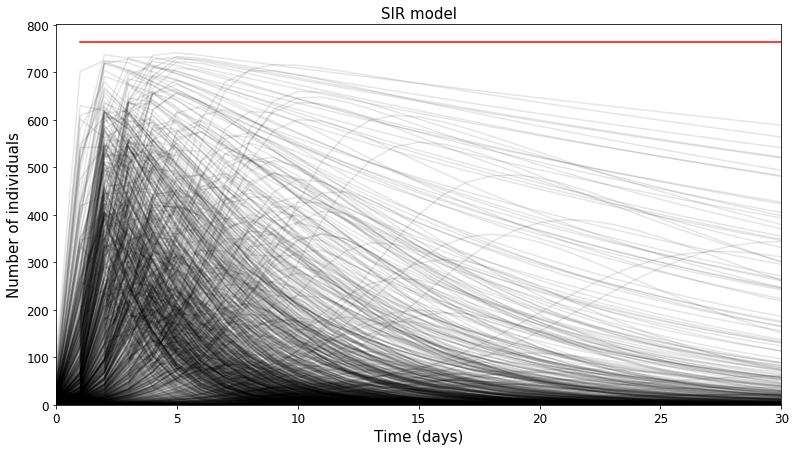

In [294]:
plt.figure(figsize=(13,7))
for i in np.array(range(0,1000)):
    plt.plot(pd.DataFrame(pd.DataFrame(fit.extract()['y'][i])[1]).rename(columns={1:'I'}), c='k', alpha=0.1)
    
plt.plot(t, [N]*n_days, c='r') # [N]*30 is to create a list of repeated values of N, length 30
plt.title("SIR model", fontsize=15)
plt.xlabel('Time (days)', fontsize=15)
plt.ylabel('Number of individuals', fontsize=15)
plt.tick_params(labelsize=12)
plt.xlim(0,30) 
plt.ylim(0,) 

## References:
1. Betancourt, M. (2018). "Towards a Principled Bayesian Workflow". Accessible at: https://github.com/betanalpha/jupyter_case_studies/blob/master/principled_bayesian_workflow/principled_bayesian_workflow.ipynb.
2. Stan Development Team. "Stan Functions Reference". Accessible at:
https://mc-stan.org/docs/2_23/functions-reference/index.html.
3. Grinsztajn et al. (2020). "Bayesian workflow for disease transmission modeling in Stan". Accessible at: https://mc-stan.org/users/documentation/case-studies/boarding_school_case_study.html#2_using_simulated_data_to_understand_our_model.